In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.style.use("fivethirtyeight")



In [20]:
%%time

df_off = pd.read_csv("data/cleaned_data.csv")


CPU times: total: 344 ms
Wall time: 340 ms


Analyse des variables : 


Analyse de la repartition des nutriscores :

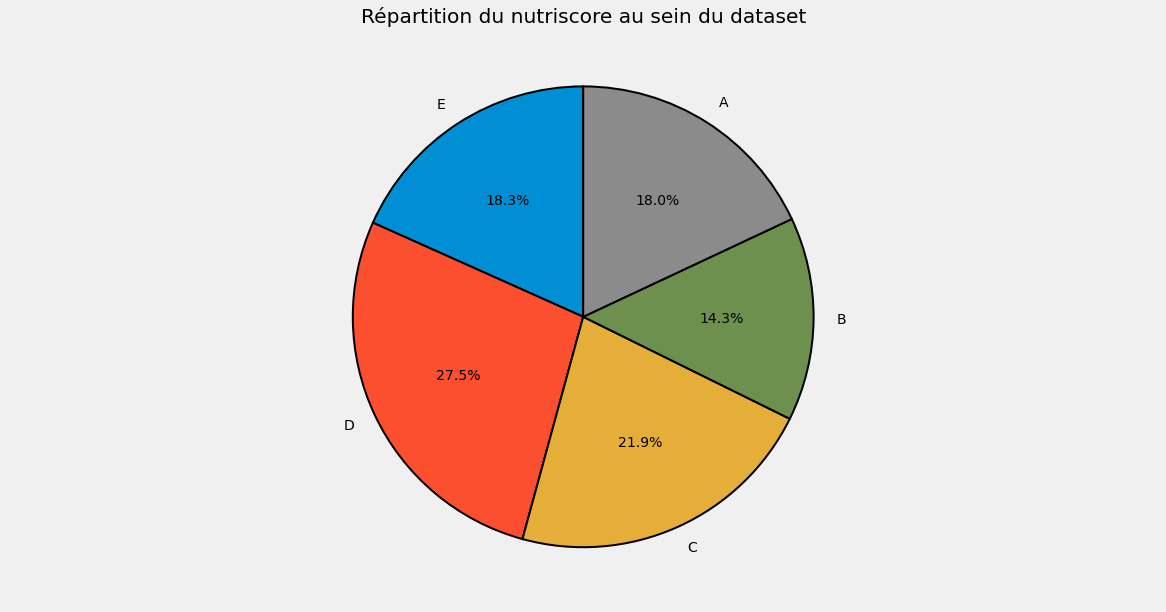

In [21]:
grades = df_off["nutrition_grade_fr"].unique()

amount = {}

for grade in grades:
        amount[grade] = df_off['nutrition_grade_fr'].value_counts()[grade]

slices = list(amount.values())
labels = [key.upper() for key in amount.keys()]


fig = plt.figure(figsize=(16,8))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, startangle=90,
        autopct='%1.1f%%', wedgeprops={'linewidth': 2,'edgecolor': 'black'})


plt.title("Répartition du nutriscore au sein du dataset")

plt.show()



In [22]:
amount

{'e': 7182, 'd': 10773, 'c': 8611, 'b': 5603, 'a': 7072}

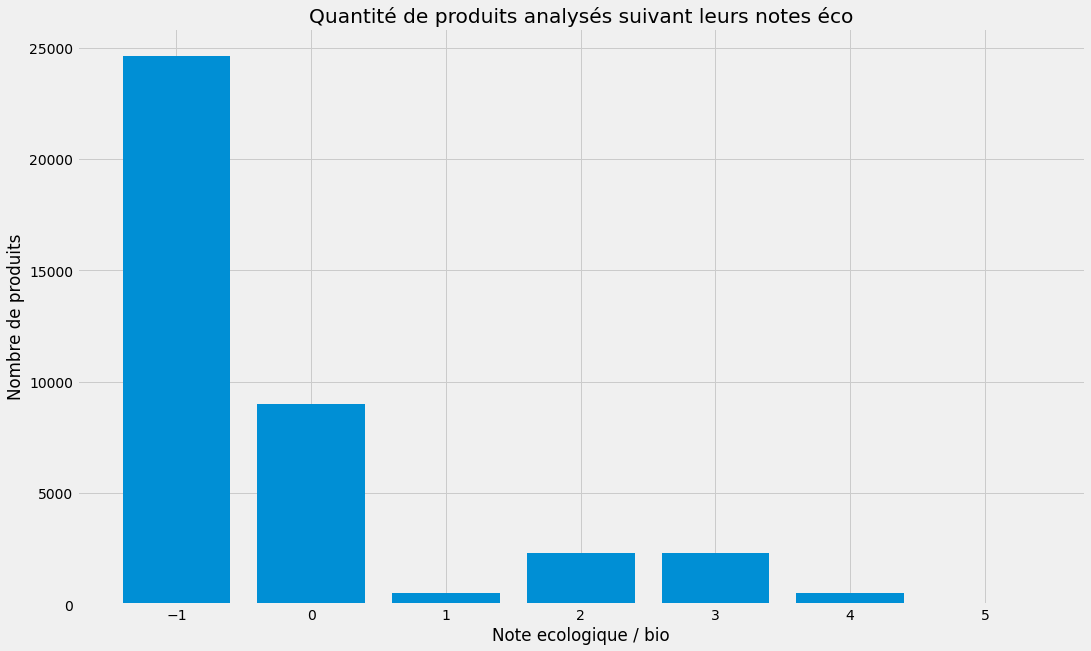

In [23]:
green_ratings = df_off["green_rating"].unique()

amount = {}

for rating in green_ratings:
        amount[rating] = df_off["green_rating"].value_counts()[rating]

axis_y = list(amount.values())
axis_x = amount.keys()


fig1 = plt.figure(figsize=(14, 8))
ax1 = fig1.add_axes([0,0,1,1])
ax1.bar(axis_x, axis_y, width=0.8)
ax1.set_ylabel("Nombre de produits")
ax1.set_xlabel("Note ecologique / bio")
title_r1 = "Quantité de produits analysés suivant leurs notes éco"

ax1.set_title(title_r1)
plt.show()